In [1]:
import numpy as np
import sympy as sp
import torch as pt
from scipy import stats

import matplotlib.pyplot as plt

np.random.seed(0)
pt.manual_seed(0)

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Exercise 1
## Regression problem by Neural Network
In this exercise we will learn how to create an artificial Neural Network (NN) to solve a regression problem, that is, given a set of data, we will find the function that passes as close as possible to all data points.
In the context of Molecular Dynamics simulations, an example of this problem is the determination of the equilibrium distribution $\pi(x)$ given a set of trajectories.

First of all, we will construct the data set.

Consider a one-dimensional system governed by the overdamped Langevin equation

$$
dx_t = - \frac{1}{m \gamma} \frac{d V(x_t)}{dx} dt + \sigma \eta_t \, ,
$$

where $x_t$ denotes the state of the system on a one-dimensional coordinate at time $t$, 
$m$ is the reduced mass and
$\gamma$ is a friction coefficient.
The variable $\sigma$ is defined as 
$$
\sigma = \sqrt{2 \frac{k_B T}{m \gamma}} \, ,
$$
where
$k_B$ is the Boltzmann constant and
$T$ is the temperature.
The last term $\eta_t$ is a Gaussian white noise such that $\langle \eta_t \rangle = 0$ and $\langle \eta_0, \, \eta_t \rangle = \delta_t$, with delta function $\delta_t$.

In order to resolve the Langevin equation, we use the Euler-Maruyama scheme.
Consider a time interval $[0,\tau]$, and a discretization in $N_{steps}$ equal subintervals $\Delta t = t_{k+1}-t_k$, with $t_k=0$ and $t_{N}=\tau$.
The Langevin equation is discretized as

$$
x_{k+1} = x_k - \frac{1}{m \gamma} \frac{d V(x_k)}{dx} dt + \sigma \sqrt{dt} \eta_t\, ,
$$

where $\eta_t \sim \mathcal{N}(0,1)$ is a random number drawn from a normal distribution with mean 0 and variance 1.

### Task 1
1. Implement the Euler-Maruyana scheme for the potential energy function

$$
V(x) = E_b (x^2 -1)^2 \, ,
$$
where $E_b=10$ $\mathrm{kJ \cdot mol^{-1}}$ denotes the height of the barrier.
Use the system parameters: $m=1$ $\mathrm{amu}$, $\gamma = 1$ $\mathrm{ps}^{-1}$, $k_B = 8.314 \cdot 10^{-3}$ $\mathrm{kJ \, K^{-1} \, mol}^{-1}$ and temperature $T=300$ $\mathrm{K}$.

2. Generate a set of trajectories
3. Calculate and plot the Boltzmann distribution using the final points of the trajectories:

$$
\pi(x) = \frac{1}{Z}e^{-beta V(x)} \, ,
$$

with $\beta = \frac{1}{k_B T}$.

#### System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu
gamma  = 1                           # ps-1 
sigma  = np.sqrt(2 * kB * T / mass / gamma )              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

print("Thermal energy:", kB * T)

Thermal energy: 2.4943389


#### Potential energy function

Text(0.5, 0, 'x')

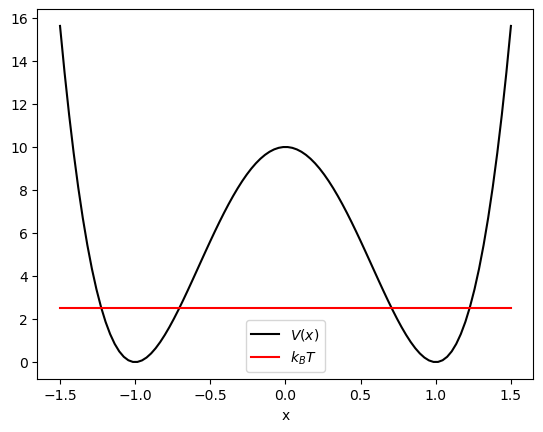

In [3]:
Eb     =  10
x      =  sp.symbols('x')
V      =  Eb*(x**2 - 1)**2

#a = 0.3
#V      =  - 1 / beta * sp.log( sp.exp( - ( x - 1 ) ** 2 / a ) + sp.exp( - ( x + 1 ) ** 2 / a ) )

gradV  =  V.diff(x)

V      =  sp.lambdify((x), V, modules=['numpy'])
gradV  =  sp.lambdify((x), gradV, modules=['numpy'])

x      =  np.linspace(-1.5, 1.5,100)
plt.plot(x, V(x), 'k-', label = r'$V(x)$')
plt.plot(x, kB*T*np.ones(100),'r', label = r'$k_B T$')
plt.legend()
plt.xlabel('x')

#### Euler-Maruyama scheme

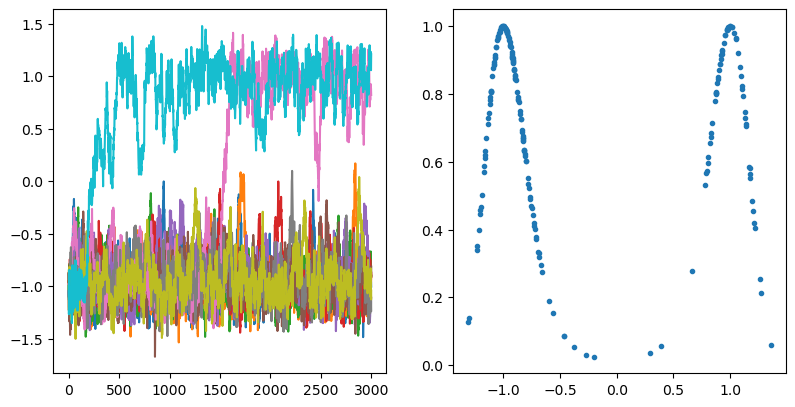

In [4]:
# Integrator time step
dt      = 0.001
sdt     = np.sqrt(dt)

# Number of timesteps
Nsteps  = 3000

# Replicas per point
Npoints = 200

# Initialize array where to store trajectories
xt            = np.zeros((Nsteps, Npoints))

# Initial states
xt[0,:]       = - 1 * np.ones(Npoints)

for k in range(Nsteps-1):
    eta          =  np.random.normal(0, 1, Npoints)
    force        =  - gradV(xt[k,:])
    xt[k+1,:]    =  xt[k,:] + 1 / mass / gamma * force * dt + sigma * eta * sdt

# Use the arrival states as input data for the NN
x0 = np.copy(xt[-1,:])

# Generate initial points from a uniform distribution
#xmin     = -2.5
#xmax     =  2.5
#x0       =  np.random.uniform(xmin, xmax, (Nreps,1))

# Calculate target data
y0  = np.exp( - beta * V(x0) )

fig, (ax) = plt.subplots(1, 2, figsize=(24*in2cm, 12*in2cm), facecolor='white')  

# Plot single trajectories
ax[0].plot(xt[:,0:-1:20])

# Plot final points
ax[1].plot(x0, y0, '.');

End first part.

## Artificial neural network
A feed-forward neural network consists of layers of interconnected nodes, commonly referred to as neurons or perceptrons. These layers are organized into an input layer, one or more hidden layers, and an output layer. Information flows through the network from the input layer, where it receives external data, to the output layer, which produces the final result. The hidden layers serve as intermediary processing stages, extracting and learning hierarchical features from the input data.

The strength of feed-forward neural networks lies in their ability to learn complex mappings between inputs and outputs through a process known as training. During training, the network adjusts its internal parameters, often referred to as weights and biases, by minimizing the difference between its predictions and the actual outcomes. This is typically achieved using optimization algorithms like gradient descent.

Activation functions play a crucial role in introducing non-linearity to the network, allowing it to model intricate relationships within the data. Common activation functions include sigmoid, hyperbolic tangent (tanh), and rectified linear unit (ReLU). The choice of activation function depends on the specific characteristics of the problem at hand.

The learning process involves adjusting the weights and biases to minimize a defined loss or error function. This optimization is achieved through backpropagation, a technique that calculates and propagates the gradients of the error with respect to the network parameters backward through the layers. This iterative process fine-tunes the network, enhancing its ability to generalize and make accurate predictions on unseen data.

### Task 2
Set up a Neural network with three hidden layers of 64, 32 and 16 nodes. Extra task: try to generalize the function to an undefined number of layers and nodes.

In [5]:
class NeuralNetwork(pt.nn.Module):
    def __init__(self, Nodes, enforce_positive=0):
        super(NeuralNetwork, self).__init__()

        # self parameters
        self.input_size        = Nodes[0]
        self.output_size       = Nodes[-1]
        self.NhiddenLayers     = len(Nodes) - 2
        self.Nodes             = Nodes
        
        self.enforce_positive  = enforce_positive

        # build NN architecture
        self.hidden_layers = pt.nn.ModuleList()

        # add layers
        self.hidden_layers.extend([pt.nn.Linear(self.input_size,    self.Nodes[1])])
        self.hidden_layers.extend([pt.nn.Linear(self.Nodes[1+l], self.Nodes[1+l+1]) for l in range(self.NhiddenLayers)])

        # the output of the last layer must be equal to 1
        #if self.Nodes[-1] > 1:
        #    self.hidden_layers.extend([pt.nn.Linear(self.Nodes[-1], 1)])

        # define activation function
        self.activation1  = pt.nn.Sigmoid()  # #
        self.activation2  = pt.nn.ReLU() 
        self.activation3  = pt.nn.Softplus(10)
        
    def forward(self, X):

        # Pass input through each hidden layer but the last one
        for layer in self.hidden_layers[:-1]:
            X = self.activation1(layer(X))

        # Apply the last layer (but not the activation function)
        X = self.hidden_layers[-1](X)

        if self.enforce_positive == 1:
            X= self.activation3(X)  #.unsqueeze(1)

        return X.squeeze()
    

### Task 3
Build a function to train the NN. As input it should take:
1. the neural network module
2. the learning rate: the learning rate is used to govern the pace (the step size) at which the neural network updates its parameters.
3. the weight decay parameter: Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function. It prevents overfitting.
4. the number of times (epochs) the NN is trained.
5. the batch size: size of the sub sample propagated during the training.
6. the input data $x_0$.
7. the target data $y_0$.

The function should implements the following phases, repeated a certain number of times, or epochs.

1. Define the batch, i.e. a sub-sample of the dataset used for the training. Sub-samples can be generated by permuting the input data at the beginning of an epoch. Training then proceeds on each sub-sample separately.

2. The first step at the beginning of training is to clear the gradients of the loss function to ensure that we aren’t tracking any unnecessary information when we train our neural network. This is necessary with pytorch as gradients are accumulated in the buffers (i.e. not overwritten) each time backward() is called.

3. Make a new prediction with the training model on the batch.

4. Measure the loss between the new predictions and the target data. Use the Mean Squared Error (MSE) which measures the average of the squared differences between predicted and actual values. It offers faster convergence in scenarios where the error values are relatively small and consistent. 

5. Compute the gradients of the loss with respect to the NN parameters using backpropagation. This step calculates how much each model parameter contributed to the error.
The "backwards" name stems from the fact that calculation of the gradient proceeds backwards through the network, with the gradient of the final layer of weights being calculated first and the gradient of the first layer of weights  being calculated last.
Partial computations of the gradient from one layer are reused in the computation of the gradient for the previous layer. 
This backwards flow of the error information allows for efficient computation of the gradient at each layer versus the naive approach of calculating the gradient of each layer separately.

6. Update the NN parameters using the computed gradients and an optimization algorithm. The optimization algorithm searches for the parameters that minimize the loss function.
Use the Adam optimizer, an extension of the Stochastic Gradient Descent which dynamically computes individual learning rates based on the past gradients and their second moments.

In [6]:
def trainNN(net, lr, wd, Nepochs, batch_size, X, Y):

    # Define the optimizer
    optimizer = pt.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

    # Define the loss function
    MSE = pt.nn.MSELoss()
        
    # Define an array where to store the loss
    loss_arr = np.zeros(Nepochs)
    
    # Train the model
    for epoch in range(Nepochs):

        permutation = pt.randperm(X.size()[0])

        for i in range(0, X.size()[0], batch_size):
            
            # Clear gradients for next training
            optimizer.zero_grad()
            
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]
            
            # Make a new prediction
            new_points  =  net( batch_x )
            
            # measure the MSE
            loss = MSE(batch_y, new_points)

            # computes the gradients of the loss with respect to the model parameters using backpropagation.
            loss.backward()

            # updates the NN parameters
            optimizer.step()

        loss_arr[epoch] = loss.item()

    return loss_arr

In the next cell, convert the input data and the target data to torch. 
Train the NN, calculate the prediction data and plot the results.

In [14]:
# Convert input data and target data to torch
pt_x0  =  pt.tensor(x0, dtype=pt.float32).unsqueeze(1)
pt_y0  =  pt.tensor(y0, dtype=pt.float32)

# Initialize neural network:
net = NeuralNetwork( Nodes = np.array([1, 64, 32, 16, 1]), enforce_positive = 1 )
#net = NeuralNetwork3()
print(net.modules)

# Train the NN
loss = trainNN(net=net, lr = 5e-3, wd = 1e-5, Nepochs = 1000, batch_size = 20, X=pt_x0, Y=pt_y0)

Y0 = net(pt_x0).detach().numpy() 

############
# Calculate Boltzmann distribution on the entire x axis
xgrid = np.linspace(-2, 2, 100)
bd    = np.exp( - beta * V(xgrid) )

# Make the prediction and transform to numpy
xgrid = np.linspace(-2, 2, 100)
pt_xgrid = pt.tensor(xgrid, dtype=pt.float32).unsqueeze(1)
ygrid    = net(pt_xgrid).detach().numpy()

<bound method Module.modules of NeuralNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (activation1): Sigmoid()
  (activation2): ReLU()
  (activation3): Softplus(beta=10, threshold=20)
)>


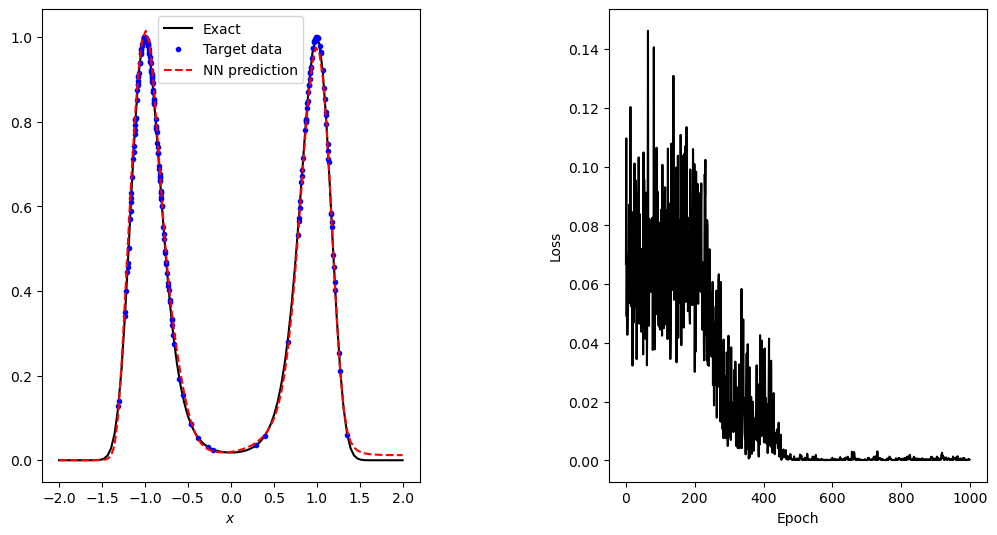

In [16]:
fig, (ax) = plt.subplots(1, 2, figsize=(24*in2cm, 12*in2cm), facecolor='white')  

ax[0].plot(xgrid, bd, 'k-' , label = 'Exact')
ax[0].plot(x0, y0, 'b.', label = 'Target data' )
ax[0].plot(xgrid, ygrid, 'r--' , label = 'NN prediction' )
ax[0].set_xlabel(r'$x$')
ax[0].legend()

ax[1].plot(loss, 'k')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.5)
fig.savefig('fitting_problem.png', format='png', dpi=900, bbox_inches='tight')